# Project 2 - Classification
## Predict customers likely to respond to a marketing campaign

### MODEL : Support Vector Machine (SVM)
#### This notebook has the SVM model
- We used the excel 'transformed_data1.xlsx'

# **Group W**
- Ana Rita Mateus - 20241483;
- Gabriel Fábrega - 20241530;
- Gift Kimbini Musharwa - 20241190;
- Marta Filipe - 20240211;
- Wilson Lima - 20241183.

# 1. Initializations and data loading

In [67]:
# Loading packages
!pip install joypy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
import joypy
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import os
from sklearn.preprocessing import StandardScaler
from fancyimpute import IterativeImputer
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import mean_squared_error, mean_absolute_error
import random
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics
import collections
from imblearn.over_sampling import SMOTE
from yellowbrick.classifier import ROCAUC
from yellowbrick.classifier import PrecisionRecallCurve
from sklearn.svm import SVC, LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.feature_selection import RFE
from imblearn.pipeline import Pipeline
import category_encoders as ce



Defaulting to user installation because normal site-packages is not writeable


# 2. Data Exploration

In [68]:
# Loading the dataset and visualizing summary statistics
ds = pd.read_excel('transformed_data1.xlsx', engine='openpyxl')
ds.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Education,2240,5,Graduation,1127,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Marital_Status,2240,6,Married,864,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Income,2240.0,NaN,NaN,NaN,51820.473097,20984.862287,1730.0,35233.5,51277.0,68413.25,118216.125
Recency,2240.0,NaN,NaN,NaN,49.109375,28.962453,0.0,24.0,49.0,74.0,99.0
Purchases_With_Discount,2240.0,NaN,NaN,NaN,0.242931,0.249713,0.0,0.0,0.30103,0.477121,0.778151
Visits_Web_LastMonth,2240.0,NaN,NaN,NaN,0.661326,0.260338,0.0,0.477121,0.778151,0.845098,1.113943
Has_Complained,2240.0,NaN,NaN,NaN,0.009375,0.096391,0.0,0.0,0.0,0.0,1.0
Response,2240.0,NaN,NaN,NaN,0.149107,0.356274,0.0,0.0,0.0,0.0,1.0
Age,2240.0,NaN,NaN,NaN,45.096875,11.694144,18.0,37.0,44.0,55.0,74.0
Year,2240.0,NaN,NaN,NaN,2013.028125,0.684554,2012.0,2013.0,2013.0,2013.0,2014.0


In [69]:
ds.columns

Index(['Education', 'Marital_Status', 'Income', 'Recency',
       'Purchases_With_Discount', 'Visits_Web_LastMonth', 'Has_Complained',
       'Response', 'Age', 'Year', 'Month', 'TotalSpent',
       'TotalAcceptedCampaigns', 'TotalPurchases', 'TotalDependents'],
      dtype='object')

## Education

We transformed the **Education** variable into a numerical format to avoid the curse of dimensionality.

In [70]:
ds['Education'].unique()

array(['Graduation', 'PhD', 'Master', 'Basic', '2n Cycle'], dtype=object)

In [71]:
education_years_map = {
    'Basic': 6,
    '2n Cycle': 9,
    'Graduation': 16,
    'Master': 18,
    'PhD': 21
}

ds['Education_Years'] = ds['Education'].map(education_years_map)

In [72]:
numerical = ['Income', 'Recency', 'Purchases_With_Discount',
       'Visits_Web_LastMonth', 'Age',
       'TotalAcceptedCampaigns', 'TotalPurchases', 'TotalDependents',
       'Education_Years']
categorical_columns = ds.select_dtypes(exclude=[np.number]).columns.tolist()

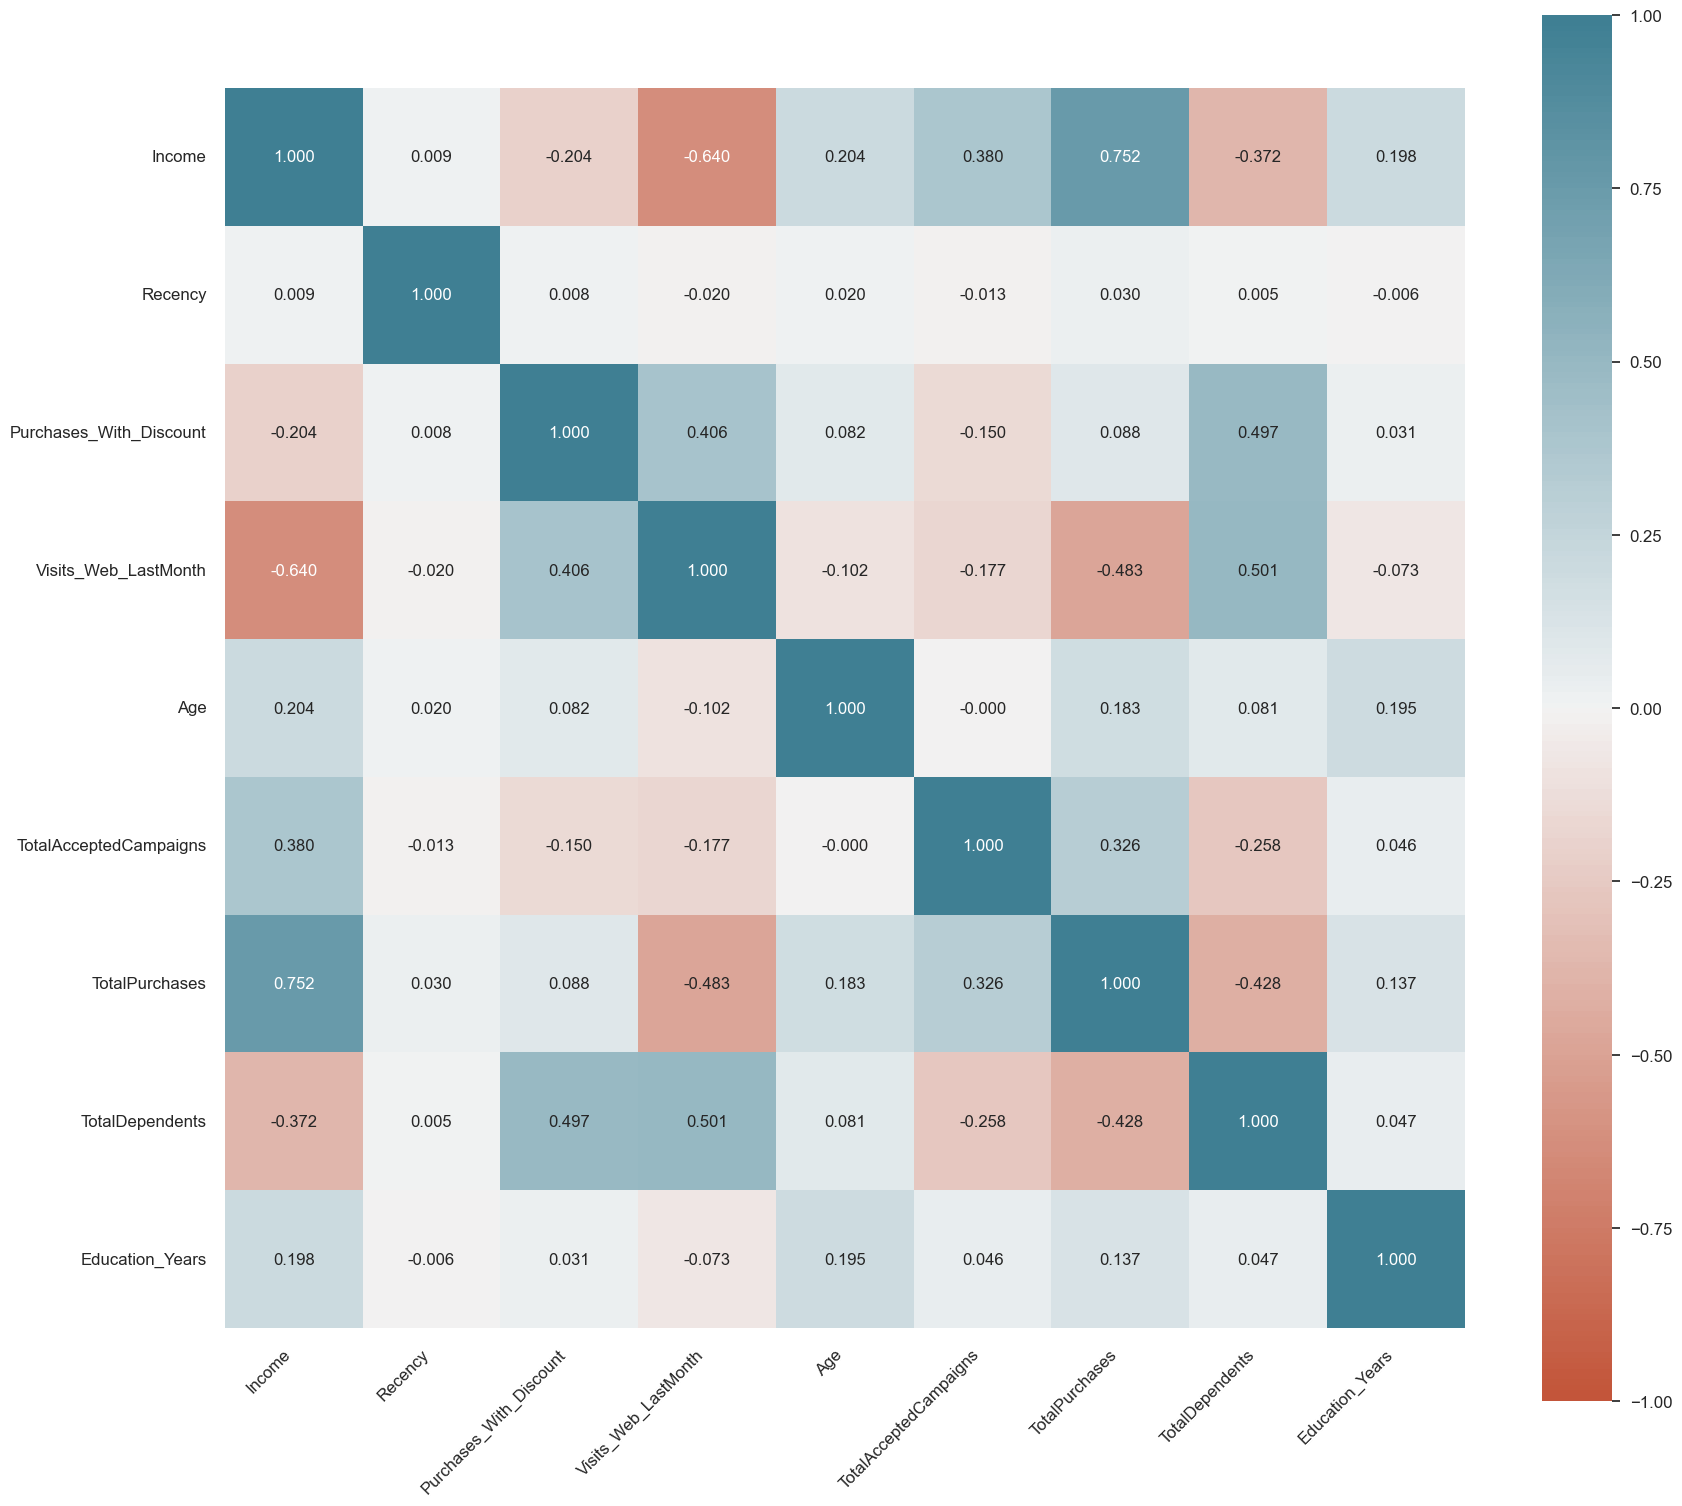

In [73]:
# Plot correlation heatmap of all numeric variables
corr = ds[numerical].corr()
plt.figure(figsize=(20, 18))
sns.set(font_scale=1.1)
ax = sns.heatmap(
    corr, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True,
    annot=True, annot_kws={"size": 12},
    fmt='.3f'
)
ax.set_xticklabels(
    ax.get_xticklabels(),
    rotation=45,
    horizontalalignment='right'
);

Here we can see the correlation between the variables, this is important to understand if there's any variables with strong correlations.
Variables with strong correlations should be avoided and in this case we have Total Purchases and Total Spent.
Dropping TotalSpent addresses high correlation (0.88) with TotalPurchases, improving model stability. Retaining TotalPurchases focuses on purchase frequency, offering insights into customer engagement beyond just total monetary value.
We're also dropping both Month and Year since they can create some noise and don't give us a lot of insight for the model.

In [74]:
ds.drop(columns=['Education', 'Year', 'Month', 'TotalSpent'], inplace=True)

In [75]:
X = ds

## 3. Data Preparation -  One hot encoding

One-hot encoding is applied before modeling to convert categorical variables into a numerical format that machine learning algorithms can understand. It avoids incorrect assumptions about category order (as in label encoding) by creating separate binary columns for each category, ensuring the model interprets them correctly.

In [19]:
# Encode categorical features into dummy variables

cols = ['Has_Complained']
X = pd.get_dummies(X, columns=cols, drop_first=True)

In [20]:
# Encode categorical variables to dummy variables
cols = ['Marital_Status']
ce_one_hot = ce.OneHotEncoder(cols = cols, use_cat_names=True)
X = ce_one_hot.fit_transform(X)

In [21]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   Marital_Status_Single    2240 non-null   int64  
 1   Marital_Status_Together  2240 non-null   int64  
 2   Marital_Status_Married   2240 non-null   int64  
 3   Marital_Status_Divorced  2240 non-null   int64  
 4   Marital_Status_Widow     2240 non-null   int64  
 5   Marital_Status_Other     2240 non-null   int64  
 6   Income                   2240 non-null   float64
 7   Recency                  2240 non-null   int64  
 8   Purchases_With_Discount  2240 non-null   float64
 9   Visits_Web_LastMonth     2240 non-null   float64
 10  Response                 2240 non-null   int64  
 11  Age                      2240 non-null   int64  
 12  TotalAcceptedCampaigns   2240 non-null   int64  
 13  TotalPurchases           2240 non-null   float64
 14  TotalDependents         

# 4. Modeling - SVM

SVM is a powerful supervised learning algorithm used primarily for classification. It works by trying to find the maximum margin between classes. It is effective in High-dimensional space where the number of features is high. Since we use one-hot encoding, this has the effect of making our dataset high-dimensional. SVM is capable of handling this effectively. Therefore making is a suitable model for our task. SVM also generalizes well, particularly with proper tuning of hyperparameters

In [22]:
# Create the Target
y = X['Response']

In [23]:
# Split into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, stratify=y, random_state=123)

In [24]:
# Remove the Target from the training
X_train = X_train.drop(['Response'],axis=1)
X_test = X_test.drop(['Response'],axis=1)

Counter({0: 1429, 1: 251})
Response
0    0.850595
1    0.149405
Name: proportion, dtype: float64


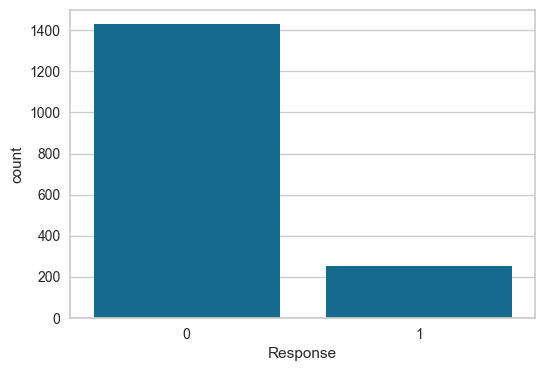

In [25]:
# Display target balance in the training dataset
print(collections.Counter(y_train))
fig, ax = plt.subplots(figsize=(6,4))
sns.countplot(x="Response", data=pd.DataFrame(data={'Response':y_train}), ax=ax)
print(y_train.value_counts(normalize=True))

Here we can see the imbalance in our dataset. We have much more no's(0) than yes(1) which is very common in marketing campaigns.
With significantly more 'no' responses, our model might become biased towards predicting 'no'. It could achieve high accuracy simply by often guessing 'no', without truly learning to identify the characteristics of customers who will respond. This leads to a model that isn't very useful for actually targeting potential responders, which is the main goal of the campaign

In [26]:
rfe_estimator = LinearSVC(max_iter=100, dual=False)

In [27]:
# Define your pipeline
pipeline = Pipeline([
    ('smote', SMOTE(sampling_strategy=0.5, random_state=123)),
    ('scaler', StandardScaler()),
    ('feature_selection', RFE(estimator=rfe_estimator, n_features_to_select=10)),
    ('classifier', SVC(probability=True))  # you can set kernel in param grid
])

To streamline our workflow and prevent data leakage, we've implemented a pipeline. This neatly combines all preprocessing steps and our SVM model.

The pipeline begins with SMOTE, a technique to address our class imbalance by generating synthetic positive responses ('1') to match the number of negative responses ('0').

Recursive Feature Elimination  works by recursively removing the least important features based on the model's weights. For a linear Support Vector Classifier (SVC), RFE uses the magnitude of the model’s coefficients to rank feature importance. It fits the model, removes the feature with the smallest absolute coefficient, and repeats the process until the desired number of features is selected.

Next, StandardScaler ensures all numerical features are on a consistent scale.

Finally, the Classifier is applied.

In [28]:
# Define parameter grid
param_grid = {
    'feature_selection__n_features_to_select': [9, 10, 11, 12, 13, 14, 15],
    'classifier__C': [0.1, 1, 5],
    'classifier__kernel': ['linear'],
    'classifier__gamma': ['scale', 0.01, 0.1, 0.2, 0.5],
}

In [29]:
# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    pipeline,
    param_distributions=param_grid,
    n_iter=30,
    scoring='roc_auc',  # or precision, recall, etc.
    cv=10,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

RandomizedSearchCV helps us automate the process of finding the best settings for our model and preprocessing steps by trying out different combinations and evaluating their performance using cross-validation and the F1-score.
Optimizing for F1-score provides a more comprehensive evaluation metric for our imbalanced classification problem, ensuring we build a model that is both effective at identifying potential responders and efficient in our marketing efforts.

In [30]:
# 4. Fit the GridSearchCV object to find the best hyperparameters
random_search.fit(X_train, y_train)

Fitting 10 folds for each of 30 candidates, totalling 300 fits


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


RandomizedSearchCV(cv=10,
                   estimator=Pipeline(steps=[('smote',
                                              SMOTE(random_state=123,
                                                    sampling_strategy=0.5)),
                                             ('scaler', StandardScaler()),
                                             ('feature_selection',
                                              RFE(estimator=LinearSVC(dual=False,
                                                                      max_iter=100),
                                                  n_features_to_select=10)),
                                             ('classifier',
                                              SVC(probability=True))]),
                   n_iter=30, n_jobs=-1,
                   param_distributions={'classifier__C': [0.1, 1, 5],
                                        'classifier__gamma': ['scale', 0.01,
                                                              0.1, 0.2, 0.5],
                                        'classifier__kernel': ['linear'],
                                        'feature_selection__n_features_to_select': [9,
                                                                                    10,
                                                                                    11,
                                                                                    12,
                                                                                    13,
                                                                                    14,
                                                                                    15]},
                   random_state=42, scoring='roc_auc', verbose=2)

This line initiates a comprehensive search across different configurations of our preprocessing steps and the model.  
It trains and evaluates each configuration multiple times using cross-validation to find the settings that are most likely   
to generalize well to unseen data and achieve the highest F1-score for predicting customer response.

In [31]:
# Best model and performance
print("Best params:", random_search.best_params_)
print("Best Precision score:", random_search.best_score_)

Best params: {'feature_selection__n_features_to_select': 14, 'classifier__kernel': 'linear', 'classifier__gamma': 0.1, 'classifier__C': 5}
Best Precision score: 0.8476245444696149


In [32]:
# You can now use the best estimator to make predictions
best = random_search.best_estimator_
y_pred = best.predict(X_test.values)

C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


## Interpretation

We used a linear Support Vector Classifier (SVC) for its balance between performance and interpretability. To simplify the model and highlight the most relevant inputs, we applied Recursive Feature Elimination (RFE). RFE selects features by iteratively removing the least important ones based on the model’s coefficients, helping reduce overfitting and improving clarity.

With a linear kernel, the SVC assigns a clear weight to each selected feature, allowing us to understand both its importance and the direction of its influence on predictions. However, RFE has limitations — it may overlook interactions between features and discard variables that are only useful in combination. Still, this approach offers a more interpretable and streamlined model.

In [33]:
rfe = random_search.best_estimator_.named_steps['feature_selection']

In [34]:
# Get feature names
if hasattr(X_train, 'columns'):
    full_feature_names = X_train.columns
else:
    full_feature_names = [f'feature_{i}' for i in range(X_train.shape[1])]

In [35]:
# Selected feature names
selected_indices = rfe.get_support(indices=True)
selected_feature_names = [full_feature_names[i] for i in selected_indices]

In [36]:
# Coefficients from the fitted LinearSVC on selected features
importance = np.abs(rfe.estimator_.coef_.flatten())

In [37]:
# Zip names and importances
selected_importances = list(zip(selected_feature_names, importance))

In [38]:
# Sort by importance
selected_importances.sort(key=lambda x: x[1], reverse=True)

In [39]:
# Unzip
sorted_features, sorted_importance = zip(*selected_importances)

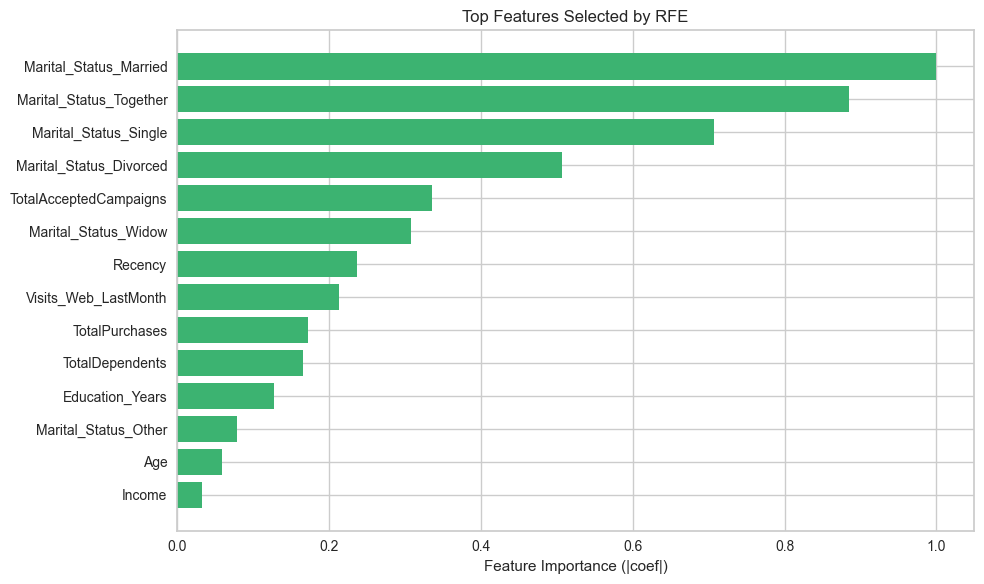

In [40]:
plt.figure(figsize=(10, 6))
plt.barh(sorted_features, sorted_importance, color='mediumseagreen')
plt.xlabel('Feature Importance (|coef|)')
plt.title('Top Features Selected by RFE')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

Marital status is the most influential factor, with Married, Together, and Single leading the importance rankings. TotalAcceptedCampaigns also stands out, showing that past engagement is a strong predictor of response.
Other relevant features include Recency, Visits_Web_LastMonth, and TotalPurchases, indicating behavioral patterns matter. Features like Age and Income had lower importance.
These coefficients reflect both impact and direction. RFE helped simplify the model by keeping only the most informative features, improving clarity and performance.

### Evaluation A

In [41]:
# predict y for X_train and X_test
y_pred_train = best.predict(X_train) 
y_pred_test = best.predict(X_test)

In [42]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, yPredTest):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, yPredTest),
               metricsObj.precision_score(yTest, yPredTest),
               metricsObj.recall_score(yTest, yPredTest),
               metricsObj.f1_score(yTest, yPredTest),
               metricsObj.roc_auc_score(yTest, yPredTest)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [43]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

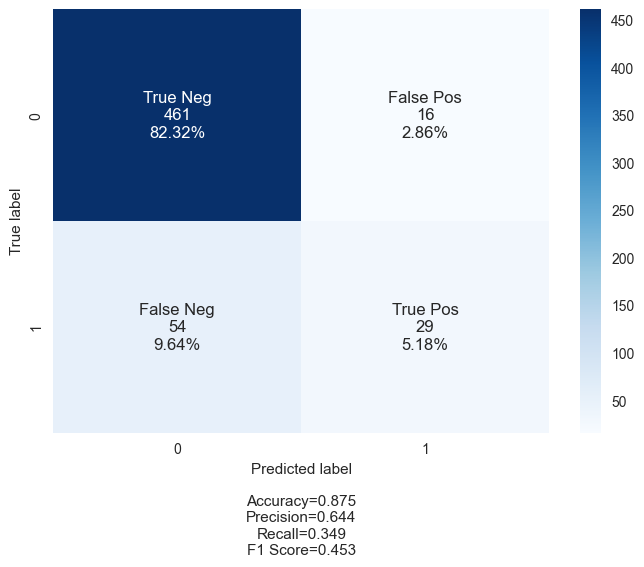

In [44]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_test)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Confusion Matrix Breakdown:**

True Negatives (461 - 82.32%): The model correctly predicted 461 customers would not respond. This avoids a contact cost of €1383 (461 clients * €3) and correctly anticipates no revenue from these individuals, this is very good because it allows the business to save €1383.  
False Positives (16 - 2.86%): The model incorrectly predicted 16 customers would respond. Contacting them costs €48 (16 clients * €3), and no revenue (€0) is generated, resulting in a net loss of 48. We also overestimated potential revenue by €176 (16 clients * €11).  
False Negatives (54 - 9.64%): The model incorrectly predicted 54 customers would not respond, but they actually would have. By not contacting them, we miss out on potential revenue of €594 (54 clients * €11).
True Positives (29 - 5.18%): The model correctly predicted 29 customers would respond. Contacting them costs €87 (29 clients * €3), and generates revenue of €319 (29 clients * €11), resulting in a net profit of €232 (€319 - €87).  

**Model Evaluation Metrics:**

Accuracy (0.870): The model correctly classified 87% of all customers.  
Precision (0.644): Of all customers predicted to respond, 64% actually did,  leading to wasted contact costs.  
Recall (0.349): The model correctly identified 34.9% of the customers who would actually respond. 
F1 Score (0.453): This value indicates a moderate imbalance between precision and recall in identifying potential responders.  

**Financial Implications and Conclusion:**  
The model performs well in identifying non-responders, with 82.32% of customers correctly classified as True Negatives, resulting in a considerable cost saving of €1383 by avoiding unnecessary contacts. However, its performance in identifying responders is less effective. The False Positives account for a minor loss of €48 due to contacting uninterested customers and an overestimation of potential revenue by €176, reflecting inefficiencies in targeting. More critically, the model misses 54 actual responders (False Negatives), resulting in a significant lost revenue opportunity of €594. While the 29 correctly predicted responders (True Positives) bring a net profit of €232, this is offset by the substantial revenue missed from uncontacted willing customers. The low Recall of 34.9% highlights the model’s limited ability to capture potential responders, and the moderate F1 score (0.453) signals an imbalance between precision and recall. Overall, despite its cost-saving strengths, the model’s underperformance in identifying actual responders limits its effectiveness from a business profitability standpoint.

In [45]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_test)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.880357,0.875000
1,PRECISION,0.695312,0.644444
2,RECALL,0.354582,0.349398
3,F1 SCORE,0.469657,0.453125
4,AUC,0.663645,0.657927


Accuracy (Overall Correct Classification):
Train: 0.880
Test: 0.875
The accuracy remains consistently high between the training and test sets, with only a minimal drop. This indicates that the model is generalizing well and is not overfitting, successfully maintaining its ability to correctly classify both responders and non-responders on unseen data.

Precision (Focus on Predicted Positives):
Train: 0.695
Test: 0.644
Precision shows a slight decline from the training to the test set, suggesting that the model is slightly less effective at correctly identifying actual responders among those it predicts will respond. This implies a small increase in false positives on new data, leading to potentially wasted contact costs.

Recall (Focus on Actual Positives):
Train: 0.355
Test: 0.349
Recall remains nearly the same across both datasets, indicating consistent but relatively low performance in identifying actual responders. The model continues to miss a significant portion of true positives in both training and testing, limiting potential revenue capture.

F1 Score (Balance Between Precision and Recall):
Train: 0.470
Test: 0.453
The F1 Score shows a minor decrease in the test set, suggesting a slight drop in the model's balanced ability to manage both false positives and false negatives. Nonetheless, the results reflect a stable but moderate performance when applied to new data.

AUC (Area Under the ROC Curve):
Train: 0.664
Test: 0.658
AUC experiences a small drop from train to test, reflecting a slight reduction in the model's ability to rank responders higher than non-responders. While the AUC is below the ideal threshold (0.70+), it still indicates some discriminatory power in prioritizing likely responders.



In [46]:
# Check AUC
# Get the decision function values for the TEST set
y_decision_test = best.decision_function(X_test)

In [47]:
# Calculate ROC curve and AUC using the test set predictions and true test labels
FP, TP, thresholds = metrics.roc_curve(y_test, y_decision_test)
print("AUC:{}".format(metrics.auc(FP, TP))) # AUC of ROC

AUC:0.8321714531080296


C:\Users\wilso\AppData\Roaming\Python\Python312\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


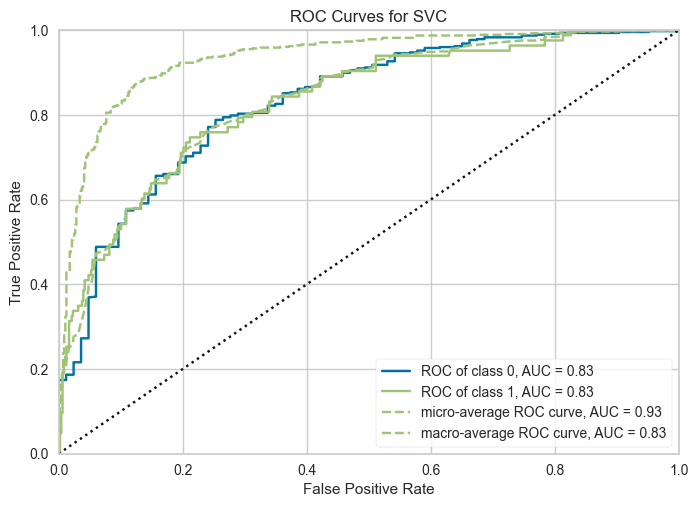

<Axes: title={'center': 'ROC Curves for SVC'}, xlabel='False Positive Rate', ylabel='True Positive Rate'>

In [48]:
# ROC curve
visualizer = ROCAUC(best, classes=['0','1'])
visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
visualizer.show()

- **Class 0 and Class 1**: AUC of 0.83 indicates that the model is effective in distinguishing between responders  and non-responders to the campaigns.
- **Micro-average AUC**: 0.93, aggregating all cases, shows the model has a very good overall performance.
- **Macro-average AUC**: 0.83, represents the unweighted average of the AUCs for each class. Since it is the same as the individual AUCs (0.83), this suggests a balanced performance across classes

All ROC curves are well above the random baseline, demonstrating strong discriminative power.


**Implications for Our Problem**
The ROC curves and AUC values (particularly the high micro-average of 0.93) suggest that this model is well-suited for predicting marketing response. Its strong ability to distinguish between likely responders and non-responders (indicated by the class AUCs of 0.83) allows for effective prioritization of customers. By leveraging this model, we can focus our marketing efforts on individuals with a higher predicted probability of response, leading to more efficient resource allocation and potentially a greater return on investment for our marketing campaigns. The balanced performance across both classes, as shown by the macro-average AUC, further supports its utility in accurately targeting both groups.

## Tuning with treshold adjustment

In [49]:
# Get predicted probabilities from your trained pipeline
y_proba = best.predict_proba(X_test)[:, 1]  # Get the probability of the positive class

 This code below performs a threshold optimization. It iterates through different probability thresholds, simulates the outcome of a marketing campaign based on those thresholds (calculating True Positives and False Positives), and then determines the net profit for each threshold. Finally, it identifies and prints the threshold that leads to the highest predicted profit. This is a crucial step in translating the model's probabilistic predictions into actionable business decisions by finding the sweet spot that balances the cost of outreach with the potential revenue from successful conversions.

In [50]:
profits = []
for t in thresholds:
    y_pred = (y_proba >= t).astype(int)
    TP = np.sum((y_test == 1) & (y_pred == 1))
    FP = np.sum((y_test == 0) & (y_pred == 1))
    
    revenue = 11 * TP
    cost = 3 * (TP + FP)
    net_profit = revenue - cost
    profits.append(net_profit)

# Find threshold with max profit
best_threshold = thresholds[np.argmax(profits)]
max_profit = np.max(profits)

print(f"Best threshold for max profit: {best_threshold:.3f} (Profit: {max_profit}€)")

Best threshold for max profit: 0.444 (Profit: 220€)


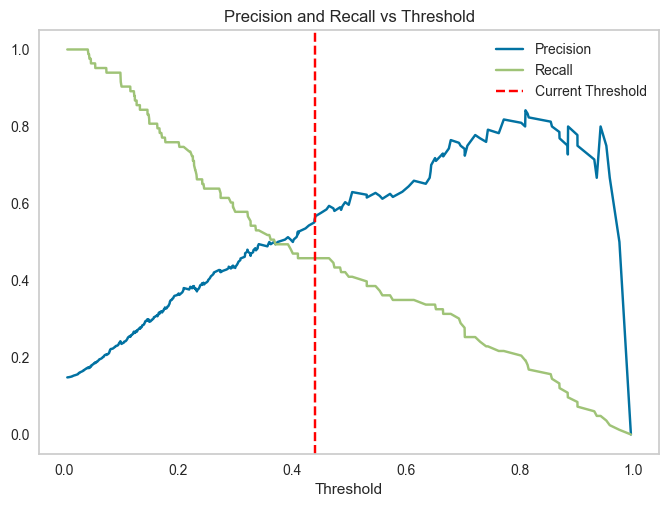

In [58]:
from sklearn.metrics import precision_recall_curve
import matplotlib.pyplot as plt

y_scores = best.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.axvline(0.44, color='red', linestyle='--', label='Current Threshold')
plt.xlabel('Threshold')
plt.legend()
plt.title('Precision and Recall vs Threshold')
plt.grid()
plt.show()

Observations:

The Precision-Recall vs. Threshold curve is a vital tool for understanding the behavior of a binary classifier and for selecting a classification threshold that best suits the specific needs and priorities of the problem by visualizing the trade-off between precision and recall across different decision points.
<p>There is an inherent trade-off between precision and recall, which vary inversely as the classification threshold changes.
<p> The best threshold is context-dependent and guided by the practical impact of classification errors.
<p> Here we can visualize the two diferences of precison and recall with diferents thresolds. The red line represnts the result of the best threshold when we have a balanced

In [59]:
# Apply your custom threshold
custom_threshold = 0.44  # You can tune this
y_pred_custom = (y_proba >= custom_threshold).astype(int)

## Evaluation B

In [60]:
# predict y for X_train and X_test
y_pred_train = best.predict(X_train) 
y_pred_test = best.predict(X_test) 

In [64]:
# Function to create dataframe with metrics
def performanceMetricsDF(metricsObj, yTrain, yPredTrain, yTest, y_pred_custom):
  measures_list = ['ACCURACY','PRECISION', 'RECALL','F1 SCORE','AUC']
  train_results = [metricsObj.accuracy_score(yTrain, yPredTrain),
                metricsObj.precision_score(yTrain, yPredTrain),
                metricsObj.recall_score(yTrain, yPredTrain),
                metricsObj.f1_score(yTrain, yPredTrain),
                metricsObj.roc_auc_score(yTrain, yPredTrain)
                ]
  test_results = [metricsObj.accuracy_score(yTest, y_pred_custom),
               metricsObj.precision_score(yTest, y_pred_custom),
               metricsObj.recall_score(yTest, y_pred_custom),
               metricsObj.f1_score(yTest, y_pred_custom),
               metricsObj.roc_auc_score(yTest, y_pred_custom)
               ]
  resultsDF = pd.DataFrame({'Measure': measures_list, 'Train': train_results, 'Test':test_results})
  return(resultsDF)

In [65]:
# Function to plot confusion matrix - Adapted from https://github.com/DTrimarchi10/confusion_matrix/blob/master/cf_matrix.py
def make_confusion_matrix(cf,
                          group_names=None,
                          categories='auto',
                          count=True,
                          percent=True,
                          cbar=True,
                          xyticks=True,
                          xyplotlabels=True,
                          sum_stats=True,
                          figsize=None,
                          cmap='Blues',
                          title=None):
    '''
    This function will make a pretty plot of an sklearn Confusion Matrix cm using a Seaborn heatmap visualization.
    Arguments
    ---------
    cf:            confusion matrix to be passed in
    group_names:   List of strings that represent the labels row by row to be shown in each square.
    categories:    List of strings containing the categories to be displayed on the x,y axis. Default is 'auto'
    count:         If True, show the raw number in the confusion matrix. Default is True.
    normalize:     If True, show the proportions for each category. Default is True.
    cbar:          If True, show the color bar. The cbar values are based off the values in the confusion matrix.
                   Default is True.
    xyticks:       If True, show x and y ticks. Default is True.
    xyplotlabels:  If True, show 'True Label' and 'Predicted Label' on the figure. Default is True.
    sum_stats:     If True, display summary statistics below the figure. Default is True.
    figsize:       Tuple representing the figure size. Default will be the matplotlib rcParams value.
    cmap:          Colormap of the values displayed from matplotlib.pyplot.cm. Default is 'Blues'
                   See http://matplotlib.org/examples/color/colormaps_reference.html
                   
    title:         Title for the heatmap. Default is None.
    '''


    # CODE TO GENERATE TEXT INSIDE EACH SQUARE
    blanks = ['' for i in range(cf.size)]

    if group_names and len(group_names)==cf.size:
        group_labels = ["{}\n".format(value) for value in group_names]
    else:
        group_labels = blanks

    if count:
        group_counts = ["{0:0.0f}\n".format(value) for value in cf.flatten()]
    else:
        group_counts = blanks

    if percent:
        group_percentages = ["{0:.2%}".format(value) for value in cf.flatten()/np.sum(cf)]
    else:
        group_percentages = blanks

    box_labels = [f"{v1}{v2}{v3}".strip() for v1, v2, v3 in zip(group_labels,group_counts,group_percentages)]
    box_labels = np.asarray(box_labels).reshape(cf.shape[0],cf.shape[1])


    # CODE TO GENERATE SUMMARY STATISTICS & TEXT FOR SUMMARY STATS
    if sum_stats:
        #Accuracy is sum of diagonal divided by total observations
        accuracy  = np.trace(cf) / float(np.sum(cf))

        #if it is a binary confusion matrix, show some more stats
        if len(cf)==2:
            #Metrics for Binary Confusion Matrices
            precision = cf[1,1] / sum(cf[:,1])
            recall    = cf[1,1] / sum(cf[1,:])
            f1_score  = 2*precision*recall / (precision + recall)
            stats_text = "\n\nAccuracy={:0.3f}\nPrecision={:0.3f}\nRecall={:0.3f}\nF1 Score={:0.3f}".format(
                accuracy,precision,recall,f1_score)
        else:
            stats_text = "\n\nAccuracy={:0.3f}".format(accuracy)
    else:
        stats_text = ""


    # SET FIGURE PARAMETERS ACCORDING TO OTHER ARGUMENTS
    if figsize==None:
        #Get default figure size if not set
        figsize = plt.rcParams.get('figure.figsize')

    if xyticks==False:
        #Do not show categories if xyticks is False
        categories=False


    # MAKE THE HEATMAP VISUALIZATION
    plt.figure(figsize=figsize)
    ax = sns.heatmap(cf,annot=box_labels, fmt="",cmap=cmap,cbar=cbar,xticklabels=categories,yticklabels=categories)

    if xyplotlabels:
        plt.ylabel('True label')
        plt.xlabel('Predicted label' + stats_text)
    else:
        plt.xlabel(stats_text)
    
    if title:
        plt.title(title)

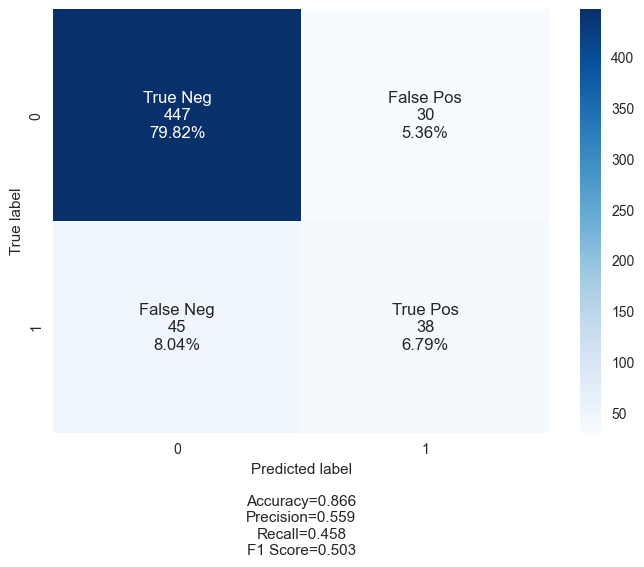

In [66]:
# Show the confusion matrix
cf = metrics.confusion_matrix(y_test,y_pred_custom)
labels = ['True Neg','False Pos','False Neg','True Pos']
categories = ['0', '1']
make_confusion_matrix(cf, 
                      group_names=labels,
                      categories=categories, 
                      cmap='Blues')

**Confusion Matrix Breakdown**

True Negatives: Decreased to 447(3%) compared to the previous state, meaning the model now incorrectly classifies 14 more non-responders as responders. This results in a higher contact cost for individuals who won't generate revenue.

False Positives: Increased to 30(3%), leading to €42 more in wasted contact costs (14 × €3) and an overestimation of €154 in potential revenue (14 × €11).

False Negatives: Decreased to 45(1.5%), which is a positive change. The model now misses 9 fewer actual responders, reducing potential missed revenue by €99 (9 × €11).

True Positives: Increased to 38(1.5%), leading to an increase in actual revenue of €99 (9 × €11), and an added contact cost of €27 (9 × €3), resulting in a net gain of €72.

Model Evaluation Metrics (Comparison to a previous state):

Accuracy: Decreased slightly , indicating a marginal decrease in overall correct classifications.
Precision: Decreased slightly , meaning that of all the customers predicted to respond, a slightly smaller proportion actually did. This suggests a small increase in wasted contact costs per predicted positive.
Recall: Decreased , which is a negative change. The model is now correctly identifying a smaller fraction of the actual responders, leading to an increase in missed revenue opportunities.
F1 Score: Decreased , indicating a less balanced performance between precision and recall in identifying responders.
Financial Implications (Qualitative Comparison):

Cost: The increase in False Positives (+2) will lead to a slightly higher contact cost (€6).
Revenue: The unchanged True Positives (0 change) and the increase in False Negatives (+2) suggest a potential for lower revenue (€0 gained from correctly identified, and €22 potential revenue lost from missing more actual responders).

Conclusion based on these changes:

The shift to this threshold has resulted in a slight decrease in the model's ability to identify actual responders (lower Recall and F1 Score) and a marginal decrease in Precision, while Accuracy has also slightly decreased. From a business perspective, the increase in false positives (higher contact cost for non-responders) combined with the increase in false negatives (more lost revenue) suggests that this threshold adjustment may not be optimal for maximizing profit compared to a previous state. The model is now missing more potential revenue for a slightly higher cost of reaching non-responders.

In [57]:
resultsDF = performanceMetricsDF(metrics, y_train, y_pred_train, y_test, y_pred_custom)
resultsDF

,Measure,Train,Test
0,ACCURACY,0.880357,0.875000
1,PRECISION,0.695312,0.622642
2,RECALL,0.354582,0.397590
3,F1 SCORE,0.469657,0.485294
4,AUC,0.663645,0.677831


## Final conclusions about this model 

The current model, after threshold tuning, demonstrates an overall improvement in performance on the test set compared to the previous model. While precision has slightly decreased—indicating a marginal increase in false positives—recall has notably improved, meaning the model is now better at identifying actual responders. This leads to an increase in the F1 Score, reflecting a more balanced trade-off between precision and recall. Accuracy and AUC have also slightly increased, suggesting better generalization and discriminative power on unseen data. Based on these changes, the threshold-tuned model offers a more effective balance for scenarios where identifying potential responders is crucial, even at the cost of slightly higher contact rates. Therefore, this adjusted model would be preferred for maximizing campaign reach and response capture.